In [6]:
#!pip install opendatasets

import tensorflow
from collections.abc import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input, Conv1D, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
#import opendatasets as od
import pandas as pd
import numpy as np
import tensorflow as tf

import os

#od.download('https://www.kaggle.com/datasets/neildavid/email-spam-classification-from-shantanu-dhakad')

def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_results(y_true, pred) -> None:
    print(classification_report(y_true, pred))

    cm = confusion_matrix(y_true, pred)
    print(cm)
    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0, 1])
    plt.show()

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_        

#Preprocessing

In [8]:
data = os.path.join('.', 'processed_data.csv')
df = pd.read_csv(data)

In [9]:
labels = pd.get_dummies(df['label'])
df = pd.concat([df, labels], axis=1)
df.rename(columns={labels.columns[0]:'labels_0', labels.columns[1]: 'labels_1'}, inplace=True)
df = df[['label', 'labels_0', 'labels_1', 'subject', 'email_to', 'email_from', 'message']]

df.head()

,label,labels_0,labels_1,subject,email_to,email_from,message
0,1,0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,0,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,0,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,0,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [10]:
print(df.isna().sum())
df = df.dropna()
print(df.shape)

label            0
labels_0         0
labels_1         0
subject        793
email_to       576
email_from       0
message       1487
dtype: int64
(72798, 7)


In [ ]:
y = df[['labels_0', 'labels_1']]
y = y.values
x = df[['message']]

In [ ]:
vectorizer = sk_text.TfidfVectorizer(min_df=.1,
                                     stop_words='english',
                                     lowercase=True,
                                     analyzer='word',
                                     max_features=5000)
matrix = vectorizer.fit_transform(x['message'])
feature_names = vectorizer.get_feature_names_out()
tfidf_data = matrix.toarray()
tf_len = len(vectorizer.vocabulary_)

x = tfidf_data
x.reshape(x.shape[0], x.shape[1],1)
print(x.shape)
print(tf_len)

(72798, 71)
71


#Model 1: CNN

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=0)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(65518, 71)
(65518, 2)
(7280, 71)
(7280, 2)


In [ ]:
model = Sequential()
model.add( Input(batch_shape=(None, x_train.shape[1], 1) ))
model.add( Conv1D(32, kernel_size=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)) )
model.add(Dense(128))
model.add(Flatten())
model.add( Dense(y_train.shape[1], activation='sigmoid') )

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5, verbose=2, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 71, 32)            128       
                                                                 
 dense (Dense)               (None, 71, 128)           4224      
                                                                 
 flatten (Flatten)           (None, 9088)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 18178     
                                                                 
Total params: 22,530
Trainable params: 22,530
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
13104/13104 - 55s - loss: 0.1324 - accuracy: 0.9520 - val_loss: 0.0966 - val_accuracy: 0.9657 - 55s/epoch - 4ms/step
Epoch 2/10
13104/13104 - 40s - loss: 0.0982 - accuracy: 0.9658 - val_loss: 0.1019 - val_accuracy: 0.9636 - 40s/epoch - 3ms/step
Epoch 3/10
13104/13104 - 40s - loss: 0.0897 - accuracy: 0.9699 - val_loss: 0.0806 - val_accuracy: 0.9746 - 40s/epoch - 3ms/step
Epoch 4/10
13104/13104 - 39s - loss: 0.0842 - accuracy: 0.9719 - val_loss: 0.0763 - val_accuracy: 0.9746 - 39s/epoch - 3ms/step
Epoch 5/10
13104/13104 - 39s - loss: 0.0812 - accuracy: 0.9736 - val_loss: 0.0736 - val_accuracy: 0.9757 - 39s/epoch - 3ms/step
Epoch 6/10
13104/13104 - 40s - loss: 0.0779 - accuracy: 0.9747 - val_loss: 0.0750 - val_accuracy: 0.9751 - 40s/epoch - 3ms/step
Epoch 7/10
13104/13104 - 39s - loss: 0.0759 - accuracy: 0.9755 - val_loss: 0.0751 - val_accuracy: 0.9738 - 39s/epoch - 3ms/step
Epoch 8/10
13104/13104 - 39s - loss: 0.0740 - accuracy: 0.9764 - val_loss: 0.0764 - val_accuracy: 0.9755

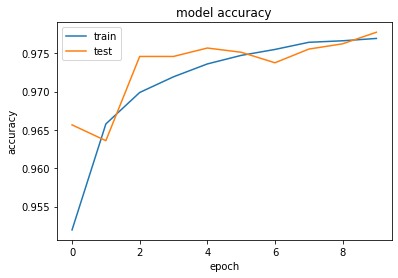

In [ ]:
history=model.fit(x_train,y_train,batch_size=5,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=10)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

228/228 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2518
           1       0.98      0.99      0.98      4762

    accuracy                           0.98      7280
   macro avg       0.98      0.97      0.98      7280
weighted avg       0.98      0.98      0.98      7280

[[2415  103]
 [  59 4703]]
Plotting confusion matrix


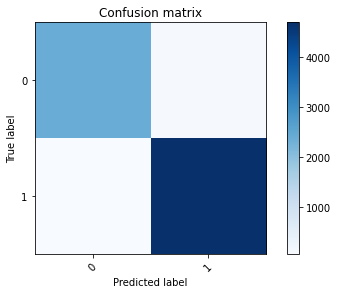

228/228 [==============================] - 1s 2ms/step


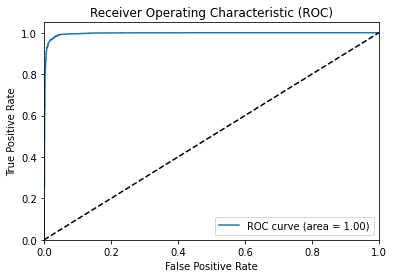

In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)

In [ ]:
print(y_true[4])
print(pred[4])

0
3.6471407e-05


#Model 2: Transfer Learning CNN

In [ ]:
import tensorflow_hub as hub

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['message'].values,
                                                    df['label'],
                                                    test_size=0.1,
                                                    random_state=42)
print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
model = Sequential()
model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
          input_shape=[],
          dtype=tf.string,
          trainable=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5, verbose=2, mode='auto')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


Epoch 1/10
2048/2048 [==============================] - 155s 75ms/step - loss: 0.0777 - accuracy: 0.9733 - val_loss: 0.0736 - val_accuracy: 0.9746
Epoch 2/10
2048/2048 [==============================] - 154s 75ms/step - loss: 0.0772 - accuracy: 0.9735 - val_loss: 0.0730 - val_accuracy: 0.9746
Epoch 3/10
2048/2048 [==============================] - 153s 75ms/step - loss: 0.0765 - accuracy: 0.9738 - val_loss: 0.0721 - val_accuracy: 0.9750
Epoch 4/10
2048/2048 [==============================] - 156s 76ms/step - loss: 0.0758 - accuracy: 0.9742 - val_loss: 0.0715 - val_accuracy: 0.9758
Epoch 5/10
2048/2048 [==============================] - 154s 75ms/step - loss: 0.0750 - accuracy: 0.9744 - val_loss: 0.0708 - val_accuracy: 0.9760
Epoch 6/10
2048/2048 [==============================] - 153s 75ms/step - loss: 0.0743 - accuracy: 0.9747 - val_loss: 0.0704 - val_accuracy: 0.9765
Epoch 7/10
2048/2048 [==============================] - 153s 75ms/step - loss: 0.0736 - accuracy: 0.9751 - val_loss: 0

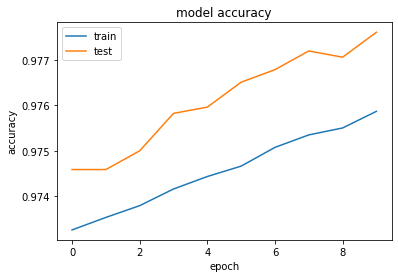

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], epochs=10)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

228/228 [==============================] - 17s 74ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2537
           1       0.98      0.99      0.98      4743

    accuracy                           0.98      7280
   macro avg       0.98      0.97      0.98      7280
weighted avg       0.98      0.98      0.98      7280

[[2442   95]
 [  68 4675]]
Plotting confusion matrix


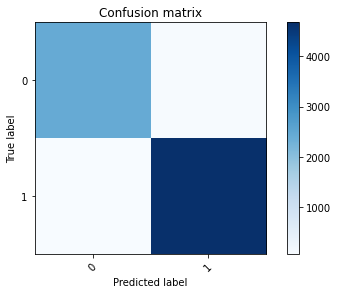

228/228 [==============================] - 17s 73ms/step


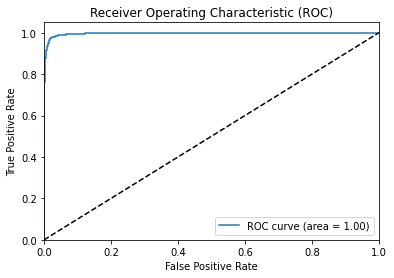

In [ ]:
pred = model.predict(x_test)
pred = pred.flatten()
y_pred = np.where(pred > 0.5, 1, 0)
y_true = y_test.astype(int).tolist()

print_results(y_true, y_pred)

pred = model.predict(x_test)
plot_roc(pred, y_true)

#Model 3: Recurrent Neural Network

In [12]:
y = df[['labels_0', 'labels_1']].values
x = df['message'].values

vocabulary_size = 100
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(x)

sequences = tokenizer.texts_to_sequences(x)
data = pad_sequences(sequences, maxlen=50)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

model = Sequential()
model.add( Embedding(20000, 100, input_length=data.shape[1]) )
model.add( LSTM(100, dropout=0.2, recurrent_dropout=0.2) )
model.add( Dense(2, activation='sigmoid') )

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5, verbose=2, mode='auto')

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

2048/2048 [==============================] - 454s 220ms/step - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.0260 - val_accuracy: 0.9911


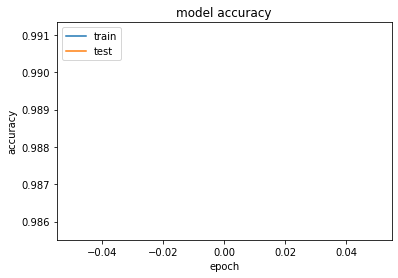

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], epochs=10)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

228/228 [==============================] - 6s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2537
           1       0.99      0.99      0.99      4743

    accuracy                           0.99      7280
   macro avg       0.99      0.99      0.99      7280
weighted avg       0.99      0.99      0.99      7280

[[2509   28]
 [  37 4706]]
Plotting confusion matrix


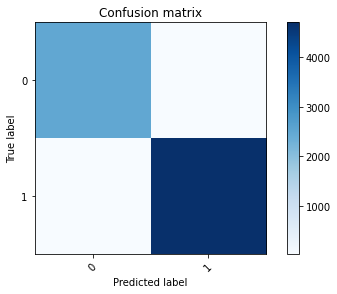

228/228 [==============================] - 3s 15ms/step


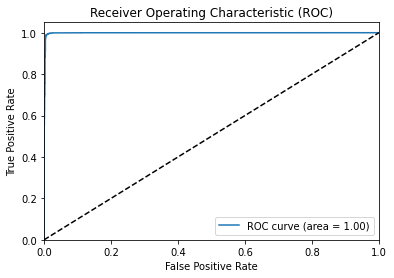

In [ ]:
pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)